画像認識


In [1]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Setting up tree (2.0.2-1) ...


In [3]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [5]:
# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [6]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [7]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 共通関数の読み込み

In [8]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 112 (delta 0), reused 2 (delta 0), pack-reused 108
Receiving objects: 100% (112/112), 21.12 MiB | 32.13 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Common Library for PyTorch
Author: M. Akaishi


データ準備

### サンプルデータのダウンロード・解凍

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# 解凍ファイルのtree表示
!tree "/content/drive/MyDrive/data/bear_panda/2_imgClassification/img"

/content/drive/MyDrive/data/bear_panda/2_imgClassification/img
├── train
│   ├── b
│   │   ├── 001l.jpg
│   │   ├── 002l.jpg
│   │   ├── 003l.jpg
│   │   ├── 004l.jpg
│   │   ├── 005l.jpg
│   │   ├── 006l.jpg
│   │   ├── 007l.jpg
│   │   ├── 008l.jpg
│   │   ├── 009l.jpg
│   │   ├── 010l.jpg
│   │   ├── 011l.jpg
│   │   ├── 012l.jpg
│   │   ├── 013l.jpg
│   │   ├── 014l.jpg
│   │   ├── 015l.jpg
│   │   ├── 016l.jpg
│   │   ├── 017l.jpg
│   │   ├── 018l.jpg
│   │   ├── 019l.jpg
│   │   ├── 020l.jpg
│   │   ├── 021l.jpg
│   │   ├── 022l.jpg
│   │   ├── 023l.jpg
│   │   ├── 024l.jpg
│   │   ├── 025l.jpg
│   │   ├── 026r.jpg
│   │   ├── 027r.jpg
│   │   ├── 028r.jpg
│   │   ├── 029r.jpg
│   │   ├── 030r.jpg
│   │   ├── 031r.JPG
│   │   ├── 032r.jpg
│   │   ├── 033r.jpg
│   │   ├── 034r.jpg
│   │   ├── 035r.jpg
│   │   ├── 036r.jpg
│   │   ├── 037r.jpg
│   │   ├── 038r.jpg
│   │   ├── 039r.jpg
│   │   └── 040r.jpg
│   └── p
│       ├── 111r.jpg
│       ├── 112r.jpg
│       ├── 113r.jpg
│   

### Transforms定義

In [15]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### データセット定義

In [16]:
# ツリーのベースディレクトリ
data_dir = '/content/drive/MyDrive/data/bear_panda/2_imgClassification/img'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['b', 'p']

/content/drive/MyDrive/data/bear_panda/2_imgClassification/img/train /content/drive/MyDrive/data/bear_panda/2_imgClassification/img/val


In [17]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir,
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir,
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir,
            transform=test_transform)

In [18]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 80件
検証データ: 20件


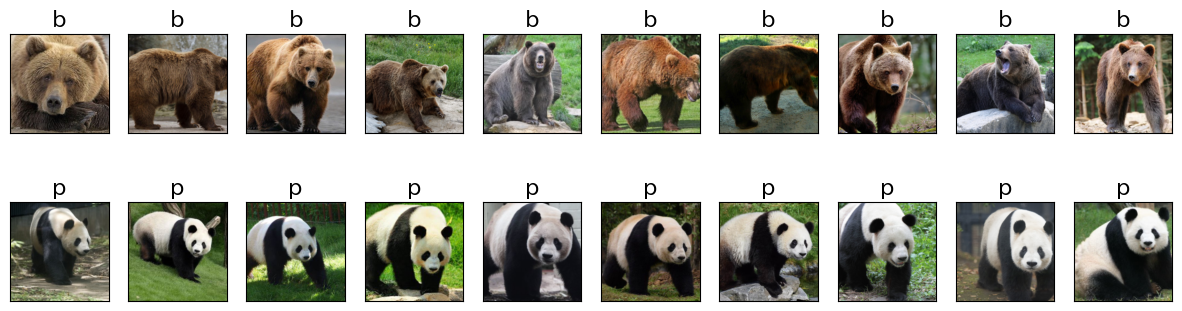

In [19]:
# 検証データ
# 最初の10個と最後の10個の表示

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### データローダー定義

In [20]:
# データローダー定義

batch_size = 10

# 訓練用
train_loader = DataLoader(train_data,
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data,
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2,
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data,
      batch_size=20, shuffle=True)

### イメージ表示

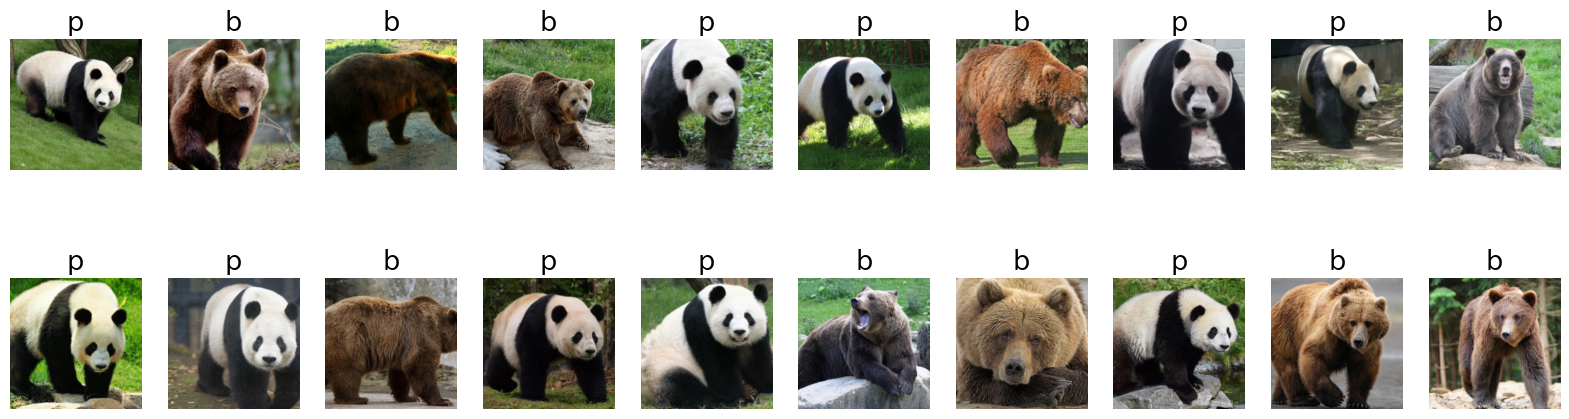

In [23]:
# 検証用データ(20件)
torch_seed()
show_images_labels(test_loader2, classes, None, None)

In [24]:
#myCode
# 訓練用データ(50件)
torch_seed()
show_images_labels(train_loader2, classes, None, None)

Output hidden; open in https://colab.research.google.com to view.

**ファインチューニングを行う**


In [25]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:09<00:00, 60.4MB/s]


In [26]:
# 学習
#num_epochs = 5
num_epochs = 100
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/100], loss: 0.58874 acc: 0.67500 val_loss: 0.17929, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.17679 acc: 0.95000 val_loss: 0.01625, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.05930 acc: 1.00000 val_loss: 0.00355, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.05950 acc: 0.96250 val_loss: 0.00333, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.03683 acc: 0.98750 val_loss: 0.00473, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.02784 acc: 1.00000 val_loss: 0.00224, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.05218 acc: 0.98750 val_loss: 0.00098, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.02376 acc: 0.98750 val_loss: 0.00076, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.03113 acc: 0.98750 val_loss: 0.00051, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.10778 acc: 0.96250 val_loss: 0.00056, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.00834 acc: 1.00000 val_loss: 0.00038, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.06881 acc: 0.97500 val_loss: 0.00044, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.02097 acc: 0.98750 val_loss: 0.00042, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.04206 acc: 0.97500 val_loss: 0.00036, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.00847 acc: 1.00000 val_loss: 0.00045, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.03294 acc: 0.98750 val_loss: 0.00046, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.01823 acc: 1.00000 val_loss: 0.00053, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.01022 acc: 1.00000 val_loss: 0.00052, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.06328 acc: 0.97500 val_loss: 0.00033, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.08209 acc: 0.96250 val_loss: 0.00024, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.12555 acc: 0.96250 val_loss: 0.00022, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.02353 acc: 1.00000 val_loss: 0.00148, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.01553 acc: 1.00000 val_loss: 0.00200, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.01809 acc: 0.98750 val_loss: 0.00157, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.03229 acc: 0.98750 val_loss: 0.00160, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.00312 acc: 1.00000 val_loss: 0.00184, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.01976 acc: 1.00000 val_loss: 0.00148, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.00405 acc: 1.00000 val_loss: 0.00056, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.01185 acc: 1.00000 val_loss: 0.00038, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.00982 acc: 1.00000 val_loss: 0.00031, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.01428 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.00735 acc: 1.00000 val_loss: 0.00013, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.01949 acc: 0.98750 val_loss: 0.00016, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.04646 acc: 0.98750 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.00161 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.00988 acc: 1.00000 val_loss: 0.00019, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.00865 acc: 1.00000 val_loss: 0.00026, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.00175 acc: 1.00000 val_loss: 0.00034, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.01571 acc: 1.00000 val_loss: 0.00025, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.03340 acc: 0.97500 val_loss: 0.00009, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.01331 acc: 1.00000 val_loss: 0.00011, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.01975 acc: 0.98750 val_loss: 0.00011, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.00085 acc: 1.00000 val_loss: 0.00009, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.00281 acc: 1.00000 val_loss: 0.00008, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.00374 acc: 1.00000 val_loss: 0.00012, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.01433 acc: 1.00000 val_loss: 0.00009, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.01434 acc: 1.00000 val_loss: 0.00009, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.12471 acc: 0.97500 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.01385 acc: 0.98750 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.02530 acc: 0.98750 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.01147 acc: 0.98750 val_loss: 0.00013, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.01064 acc: 1.00000 val_loss: 0.00008, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.05446 acc: 0.98750 val_loss: 0.00008, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.01782 acc: 0.98750 val_loss: 0.00013, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.03758 acc: 0.98750 val_loss: 0.00008, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.01208 acc: 1.00000 val_loss: 0.00014, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.02819 acc: 0.98750 val_loss: 0.00012, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.01022 acc: 1.00000 val_loss: 0.00010, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.06386 acc: 0.96250 val_loss: 0.00006, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.02124 acc: 0.98750 val_loss: 0.00006, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.03392 acc: 0.96250 val_loss: 0.00007, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.00532 acc: 1.00000 val_loss: 0.00006, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.00319 acc: 1.00000 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.00484 acc: 1.00000 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.00307 acc: 1.00000 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.05254 acc: 0.98750 val_loss: 0.00004, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.00719 acc: 1.00000 val_loss: 0.00004, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.01798 acc: 0.98750 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.01453 acc: 0.98750 val_loss: 0.00009, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.01002 acc: 1.00000 val_loss: 0.00010, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.00282 acc: 1.00000 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.00315 acc: 1.00000 val_loss: 0.00004, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.00128 acc: 1.00000 val_loss: 0.00006, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.00868 acc: 1.00000 val_loss: 0.00004, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.00105 acc: 1.00000 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.00164 acc: 1.00000 val_loss: 0.00011, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.00332 acc: 1.00000 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.02879 acc: 0.98750 val_loss: 0.00005, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.00310 acc: 1.00000 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.01218 acc: 1.00000 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.02206 acc: 0.98750 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.06022 acc: 0.97500 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.00396 acc: 1.00000 val_loss: 0.00003, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.00132 acc: 1.00000 val_loss: 0.00003, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.00195 acc: 1.00000 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.00536 acc: 1.00000 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.01991 acc: 1.00000 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.00048 acc: 1.00000 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.00337 acc: 1.00000 val_loss: 0.00003, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.02834 acc: 0.97500 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.02780 acc: 0.98750 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.03065 acc: 0.98750 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.00528 acc: 1.00000 val_loss: 0.00003, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.01366 acc: 0.98750 val_loss: 0.00003, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.00101 acc: 1.00000 val_loss: 0.00003, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.00116 acc: 1.00000 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.00698 acc: 1.00000 val_loss: 0.00003, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.00121 acc: 1.00000 val_loss: 0.00003, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.00203 acc: 1.00000 val_loss: 0.00002, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.00362 acc: 1.00000 val_loss: 0.00002, val_acc: 1.00000


初期状態: 損失: 0.17929 精度: 1.00000
最終状態: 損失: 0.00002 精度: 1.00000


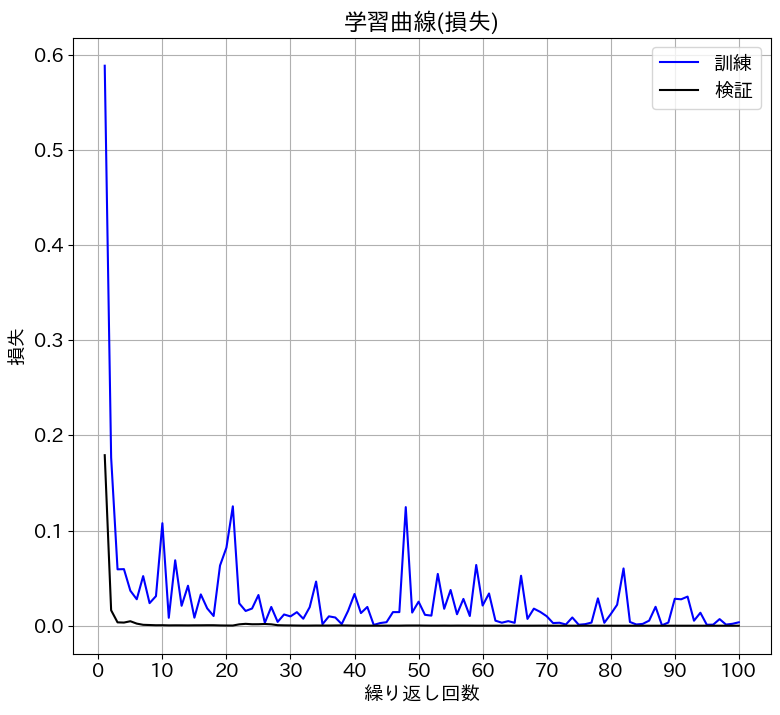

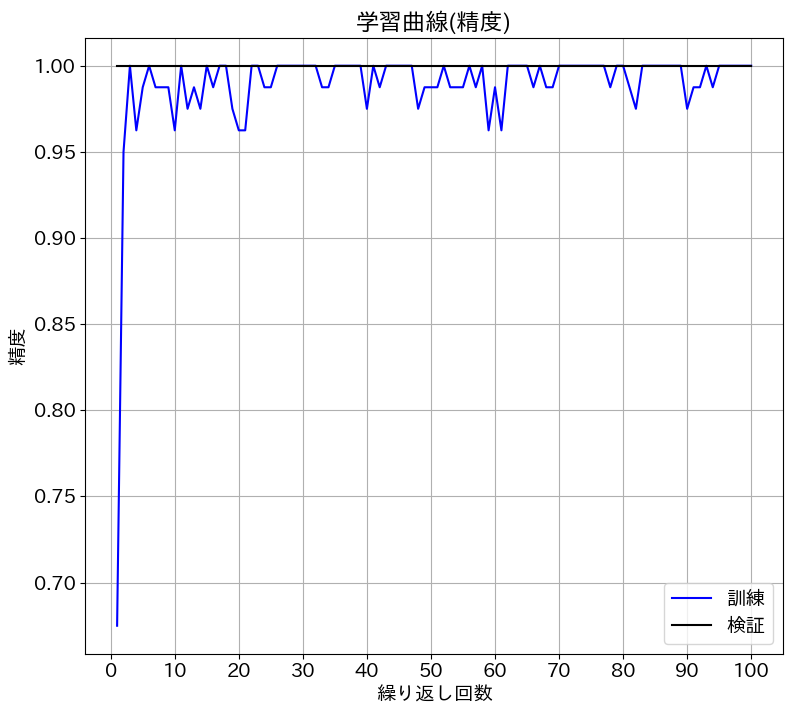

In [27]:
# 結果確認
evaluate_history(history)

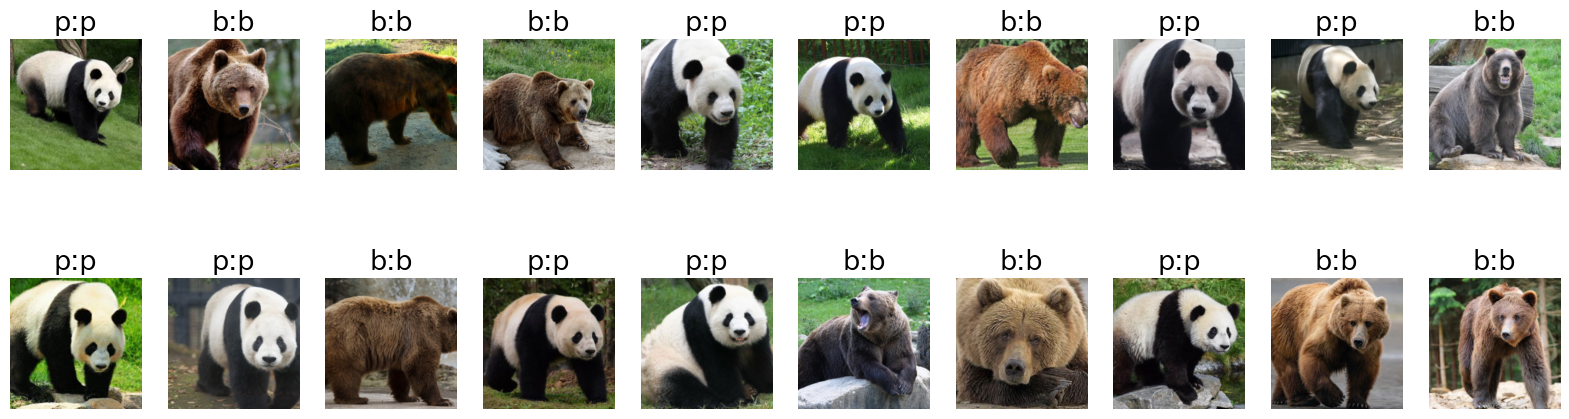

In [28]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)